In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import make_pipeline
from PIL import Image
from wordcloud import STOPWORDS, WordCloud
import requests
from bs4 import BeautifulSoup
import pickle
import warnings
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# Ignore warning messages
warnings.filterwarnings('ignore')

In [2]:
phish_data = pd.read_csv("phishing_site_urls.csv", encoding='utf-8')       # Load the phishing dataset

In [3]:
phish_data.head()                                                          # Display the first few rows of the dataset

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [4]:
phish_data.tail()                                                         # Display the last few rows of the dataset

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [5]:
phish_data.info()                        # Display dataset information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [6]:
phish_data['Label'].value_counts()           # Count the number of samples in each class

Label
good    392924
bad     156422
Name: count, dtype: int64

In [7]:
phish_data.isnull().sum()                  # Check for missing values in the dataset

URL      0
Label    0
dtype: int64

In [8]:
melted = pd.melt(phish_data, value_vars=["Label"])

<Axes: xlabel='value', ylabel='count'>

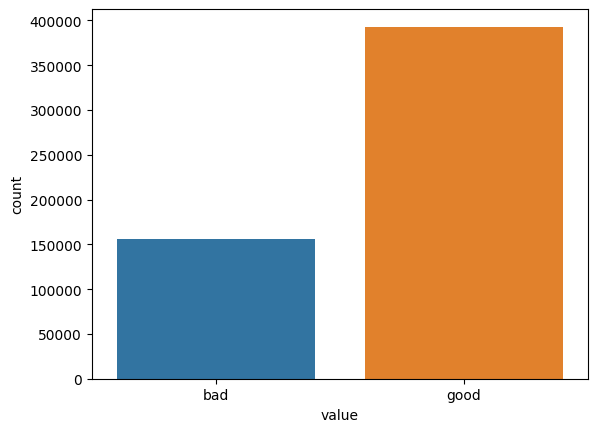

In [9]:
sns.countplot(x='value', data=melted)           # Create a count plot to visualize class distribution

In [10]:
# Initialize tokenizer and stemmer for text preprocessing
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = SnowballStemmer("english")

In [11]:
# Tokenize, stem, and join the text data
phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t))
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))

In [12]:
# Data Preprocessing: Convert text to lowercase and remove stopwords
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

phish_data['text_sent'] = phish_data['text_sent'].apply(lambda x: ' '.join(word.lower() for word in x.split() if word.lower() not in stop_words))

In [13]:
phish_data.sample(5)                   # Displaying a sample of preprocessed data

,URL,Label,text_tokenized,text_stemmed,text_sent
277963,amazon.com/ddrum-Shawn-Drover-Aluminum-Signatu...,good,"[amazon, com, ddrum, Shawn, Drover, Aluminum, ...","[amazon, com, ddrum, shawn, drover, aluminum, ...",amazon com ddrum shawn drover aluminum signatu...
303798,childrenskidsfurniture.com/,good,"[childrenskidsfurniture, com]","[childrenskidsfurnitur, com]",childrenskidsfurnitur com
215768,movies.msn.com/movies/movie/a-serious-man/,good,"[movies, msn, com, movies, movie, a, serious, ...","[movi, msn, com, movi, movi, a, serious, man]",movi msn com movi movi serious man
285657,auburn.edu/~vestmon/xmas_cnt.htm,good,"[auburn, edu, vestmon, xmas, cnt, htm]","[auburn, edu, vestmon, xmas, cnt, htm]",auburn edu vestmon xmas cnt htm
81517,www.holidaygraphics.com/thanksgiving/,good,"[www, holidaygraphics, com, thanksgiving]","[www, holidaygraph, com, thanksgiv]",www holidaygraph com thanksgiv


In [14]:
# Slice the dataset into "bad" and "good" sites
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [15]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel ffb dca cce f login skype com en cgi bin...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get herf secur ...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [16]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g xz fn ...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",ko l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag vie cf b vc f b g sd vd qt n ...


In [17]:
def scrape_website_text(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        text = " ".join([p.text for p in soup.find_all('p')])  # Extract text from <p> tags

        # Data Preprocessing: Convert text to lowercase and remove stopwords
        text = ' '.join(word.lower() for word in text.split() if word.lower() not in stop_words)

        return text
    except Exception as e:
        print(f"Error scraping {url}: {str(e)}")
        return ""

In [18]:
# List of URLs to scrape text from
scrape_urls = ['https://uims.cuchd.in/uims/', 'https://www.wikipedia.org']

In [19]:
# Combine and scrape text from the specified URLs
website_text = " ".join([scrape_website_text(url) for url in scrape_urls])

In [20]:
# TF-IDF feature extraction
tfidf_vectorizer = TfidfVectorizer()
tfidf_feature = tfidf_vectorizer.fit_transform([website_text])

In [21]:
# Function to create and plot a word cloud from text data

def plot_wordcloud_from_data(data, title):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com', 'http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords,
                          max_words=400,
                          max_font_size=120,
                          random_state=42)
    wordcloud.generate(data)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontdict={'size': 40, 'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

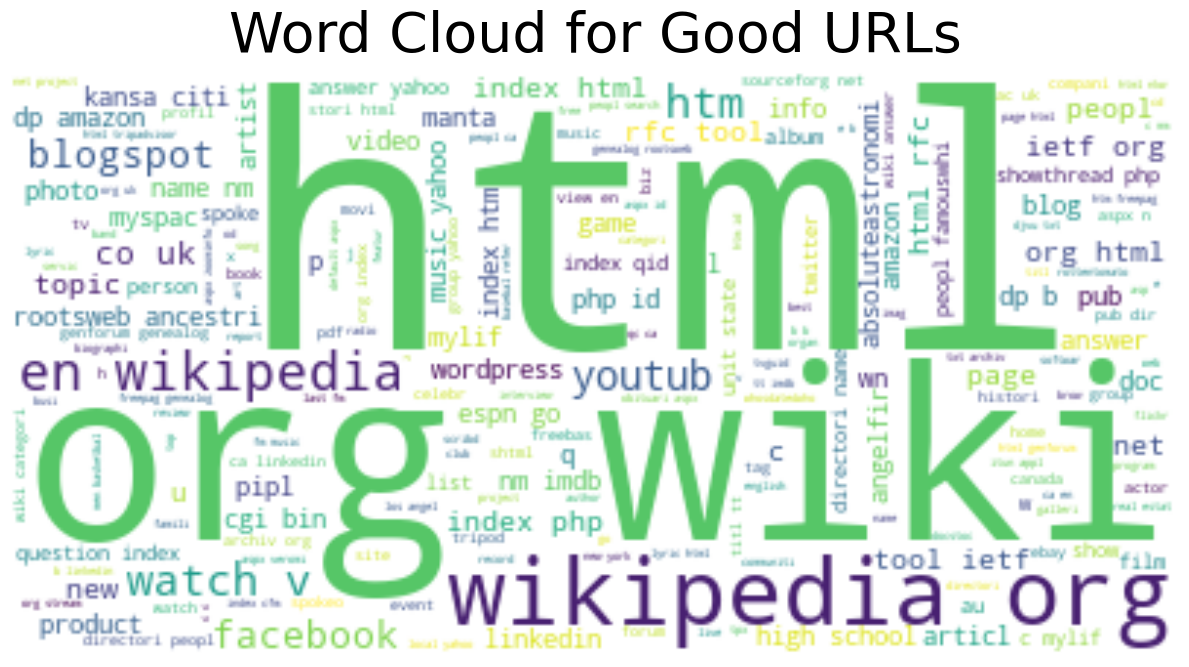

In [22]:
# Generate and plot a word cloud for good URLs
good_sites_text = " ".join(phish_data[phish_data['Label'] == 'good']['text_sent'])
plot_wordcloud_from_data(good_sites_text, title='Word Cloud for Good URLs')

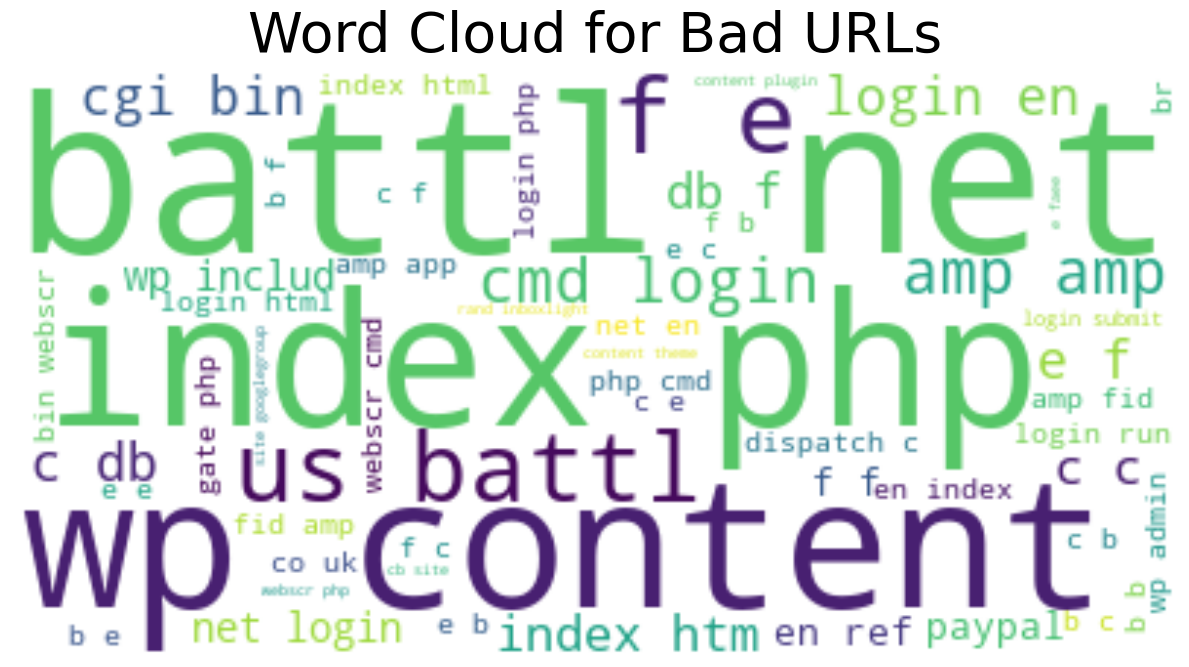

In [23]:
# Generate and plot a word cloud for bad URLs
bad_sites_text = " ".join(phish_data[phish_data['Label'] == 'bad']['text_sent'])
plot_wordcloud_from_data(bad_sites_text, title='Word Cloud for Bad URLs')

In [24]:
from selenium import webdriver

def scrape_website_text(url):
    try:
        options = webdriver.ChromeOptions()
        # Specify the path to your Chrome browser executable
        options.binary_location = 'C:/Program Files/Google/Chrome/Application/chrome.exe'
        options.add_argument("--no-sandbox")

        driver = webdriver.Chrome(options=options)  # Omit executable_path
        driver.get(url)
        time.sleep(3)  # Allow time for the page to load
        page_source = driver.page_source
        driver.quit()

        soup = BeautifulSoup(page_source, "html.parser")
        text = " ".join([p.text for p in soup.find_all('p')])  # Extract text from <p> tags
        return text
    except Exception as e:
        print(f"Error scraping {url}: {str(e)}")
        return ""

In [25]:
# List of URLs to scrape text from using Selenium
scrape_urls = ['https://www.segurossura.com.co/', 'https://en.wikipedia.org/wiki/Cricket_World_Cup']

In [26]:
# Combine and scrape text from the specified URLs using Selenium
website_text = " ".join([scrape_website_text(url) for url in scrape_urls])

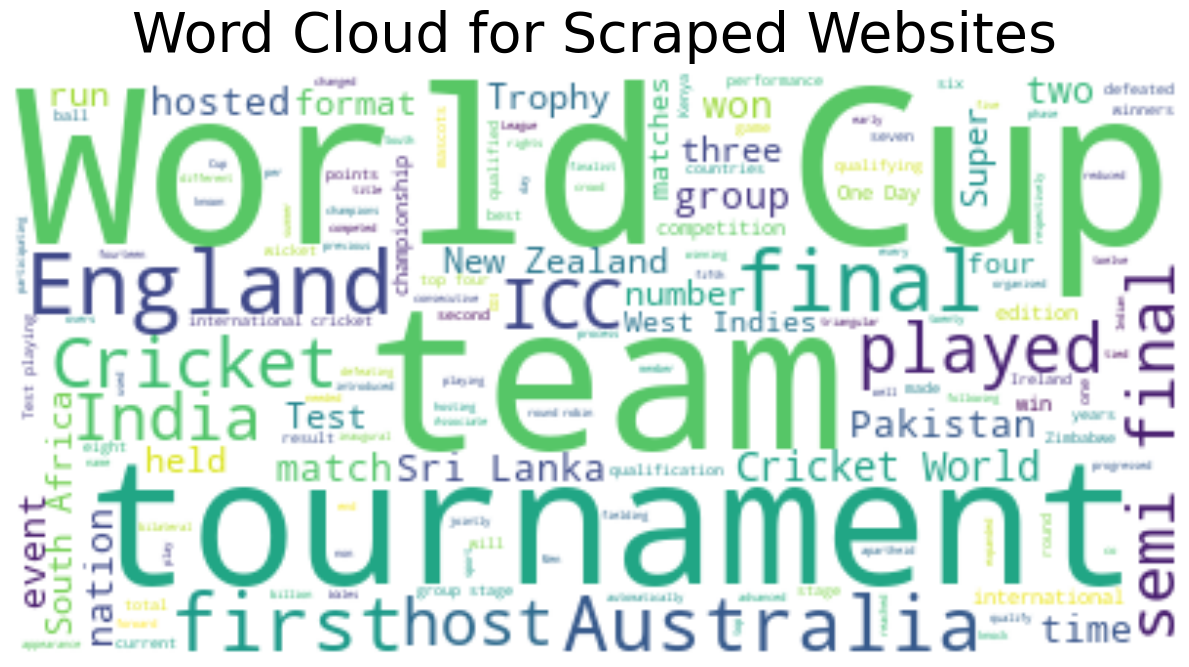

In [27]:
# Function to create and plot a word cloud from text data
def plot_wordcloud(text, max_words=400, max_font_size=120, title=None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords,
                          max_words=max_words,
                          max_font_size=max_font_size,
                          random_state=42)
    wordcloud.generate(text)

    plt.figure(figsize=(12, 8))
    if image_color:
        image_colors = ImageColorGenerator(np.array(Image.open("star.png")))
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    else:
        plt.imshow(wordcloud, interpolation="bilinear")

    plt.title(title, fontdict={'size': title_size, 'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

plot_wordcloud(website_text, title='Word Cloud for Scraped Websites')

plt.show()

In [28]:
# Handling Imbalanced Data: Resample the minority class (phishing)
phish_data_majority = phish_data[phish_data['Label'] == 'good']
phish_data_minority = phish_data[phish_data['Label'] == 'bad']

In [29]:
from sklearn.utils import resample

phish_data_minority_upsampled = resample(phish_data_minority,
                                         replace=True,
                                         n_samples=len(phish_data_majority),
                                         random_state=42)
phish_data_upsampled = pd.concat([phish_data_majority, phish_data_minority_upsampled])

In [30]:
# Create a CountVectorizer object for text feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
cv = CountVectorizer()

In [31]:
all_text = phish_data.text_sent
# Fit the CountVectorizer on the combined data
cv.fit(all_text)
feature = cv.transform(all_text)  # Transform your text data into features
print(feature[:5].toarray())  # Print the first 5 samples as an example

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [32]:
trainX, testX, trainY, testY = train_test_split(phish_data_upsampled['text_sent'], phish_data_upsampled['Label'])

In [33]:
# Initialize a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the number of features as needed

In [34]:
# Fit and transform the training text data
trainX_tfidf = tfidf_vectorizer.fit_transform(trainX)

In [35]:
# Transform the test text data using the same vectorizer
testX_tfidf = tfidf_vectorizer.transform(testX)

In [36]:
# Initialize a Logistic Regression model
lr = LogisticRegression()

In [37]:
# Hyperparameter Tuning: Grid Search for Logistic Regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(lr, param_grid, cv=5)
grid_search.fit(trainX_tfidf, trainY)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]})

In [38]:
# Get the best hyperparameter
best_C = grid_search.best_params_['C']

In [39]:
# Train Logistic Regression with the best hyperparameter
lr = LogisticRegression(C=best_C)
lr.fit(trainX_tfidf, trainY)

LogisticRegression(C=10)

In [40]:
# Predict on the test set
predictions = lr.predict(testX_tfidf)

In [41]:
# Evaluate the model
report = classification_report(testY, predictions)
print(report)

              precision    recall  f1-score   support

         bad       0.95      0.91      0.93     98157
        good       0.91      0.95      0.93     98305

    accuracy                           0.93    196462
   macro avg       0.93      0.93      0.93    196462
weighted avg       0.93      0.93      0.93    196462



In [42]:
from sklearn.metrics import accuracy_score
Scores_ml = {}

# Predict on the test set using the trained logistic regression model
lr_predictions = lr.predict(testX_tfidf)

# Calculate accuracy on the test set
lr_accuracy = accuracy_score(testY, lr_predictions)

# Store the accuracy score in the Scores_ml dictionary
Scores_ml['Logistic Regression'] = np.round(lr_accuracy, 2)

# Print the accuracy
print(f"Logistic Regression Accuracy: {lr_accuracy:.2f}")

Logistic Regression Accuracy: 0.93


In [43]:
# Display accuracy and classification report for Logistic Regression
#print("Logistic Regression Accuracy:", lr_accuracy)

In [44]:
print("Logistic Regression Classification Report:")
print(classification_report(testY, lr_predictions, target_names=['Bad', 'Good']))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         Bad       0.95      0.91      0.93     98157
        Good       0.91      0.95      0.93     98305

    accuracy                           0.93    196462
   macro avg       0.93      0.93      0.93    196462
weighted avg       0.93      0.93      0.93    196462



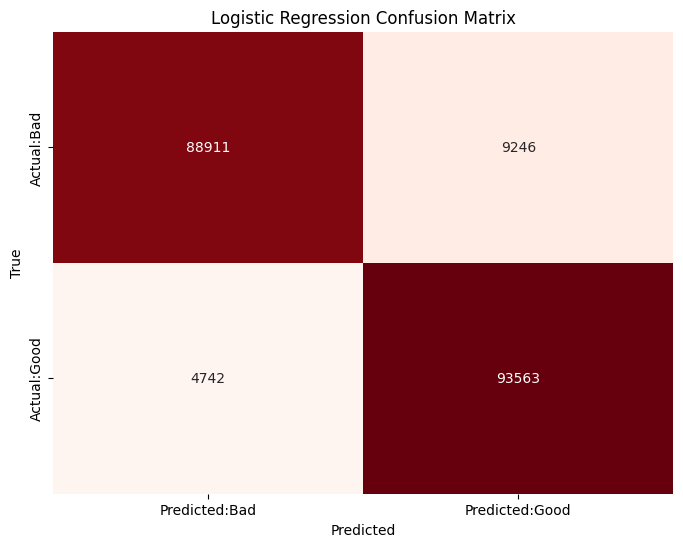

In [45]:
lr_confusion_matrix = confusion_matrix(testY, lr_predictions)
lr_confusion_df = pd.DataFrame(lr_confusion_matrix, columns=['Predicted:Bad', 'Predicted:Good'], index=['Actual:Bad', 'Actual:Good'])
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(lr_confusion_df, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [46]:
# Multinomial Naive Bayes
mnb = MultinomialNB()
# Fit the classifier on the TF-IDF transformed training data
mnb.fit(trainX_tfidf, trainY)

# Predict on the test set
mnb_predictions = mnb.predict(testX_tfidf)

# Calculate accuracy on the test set
mnb_accuracy = accuracy_score(testY, mnb_predictions)

Scores_ml['MultinomialNB'] = np.round(mnb_accuracy,2)

In [47]:
# Predict on the test set using the trained Multinomial Naive Bayes model
mnb_predictions = mnb.predict(testX_tfidf)

# Calculate accuracy on the test set
mnb_accuracy = accuracy_score(testY, mnb_predictions)
mnb_confusion_matrix = confusion_matrix(testY, mnb_predictions)

In [48]:
# Display accuracy and classification report for Multinomial Naive Bayes
print("\nMultinomial Naive Bayes Accuracy:", mnb_accuracy)
print("Multinomial Naive Bayes Classification Report:")
print(classification_report(testY, mnb_predictions, target_names=['Bad', 'Good']))


Multinomial Naive Bayes Accuracy: 0.9175871160835174
Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

         Bad       0.93      0.90      0.92     98157
        Good       0.91      0.93      0.92     98305

    accuracy                           0.92    196462
   macro avg       0.92      0.92      0.92    196462
weighted avg       0.92      0.92      0.92    196462



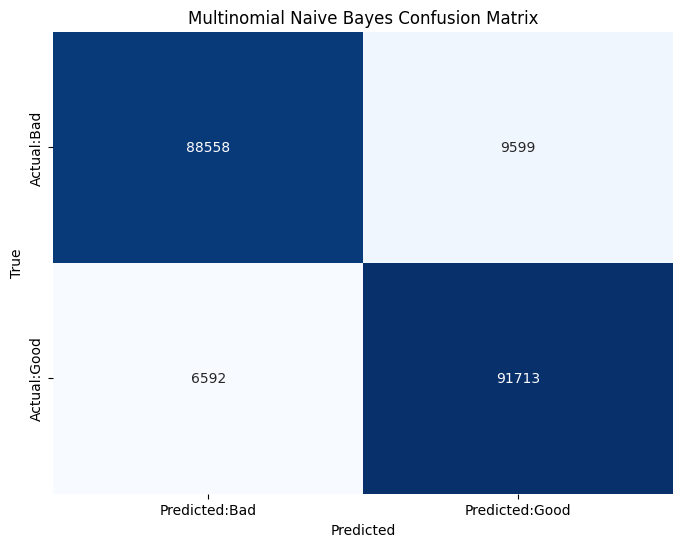

In [49]:
# Confusion Matrix for Multinomial Naive Bayes
mnb_confusion_matrix = confusion_matrix(testY, mnb_predictions)
mnb_confusion_df = pd.DataFrame(mnb_confusion_matrix, columns=['Predicted:Bad', 'Predicted:Good'], index=['Actual:Bad', 'Actual:Good'])
plt.figure(figsize=(8, 6))
sns.heatmap(mnb_confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Multinomial Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [50]:
acc = pd.DataFrame.from_dict(Scores_ml, orient='index', columns=['Accuracy'])

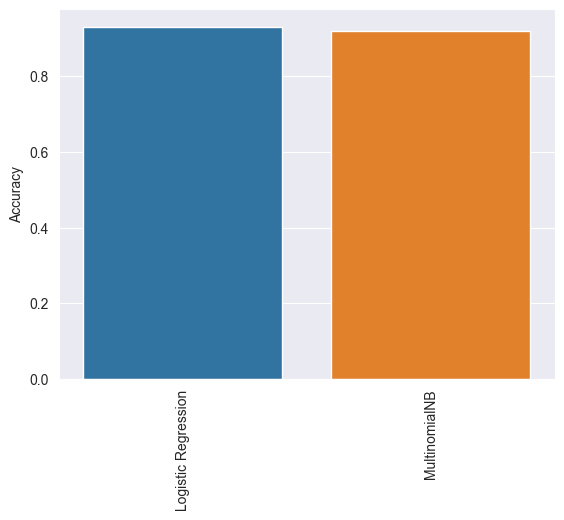

In [51]:
# Create a bar plot with seaborn
sns.set_style('darkgrid')
sns.barplot(x=acc.index, y=acc['Accuracy'])  # Specify x and y explicitly

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

# Display the plot
plt.show()
acc = pd.DataFrame.from_dict(Scores_ml, orient='index', columns=['Accuracy'])

In [52]:
from sklearn.pipeline import Pipeline
# Create a pipeline that includes CountVectorizer and Logistic Regression
lr_pipeline = make_pipeline(CountVectorizer(tokenizer=RegexpTokenizer(r'[A-Za-z]+').tokenize, stop_words='english'), LogisticRegression())

In [53]:
# Split the dataset into training and testing sets
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)

In [54]:
# Fit the pipeline on the training data
lr_pipeline.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [55]:
# Predict using the pipeline
lr_pipeline_predictions = lr_pipeline.predict(testX)
lr_pipeline_accuracy = accuracy_score(testY, lr_pipeline_predictions)
lr_pipeline.score(testX,testY)

0.9657557686566621

In [56]:
# Display accuracy Logistic Regression from the pipeline
print("Logistic Regression (Pipeline) Accuracy:", lr_pipeline_accuracy)

Logistic Regression (Pipeline) Accuracy: 0.9657557686566621


In [57]:
# Print the classification report for Logistic Regression from the pipeline
print("Logistic Regression pipeline Classification Report:")
print(classification_report(testY, lr_pipeline_predictions, target_names=['Bad', 'Good']))

Logistic Regression pipeline Classification Report:
              precision    recall  f1-score   support

         Bad       0.97      0.91      0.94     39131
        Good       0.96      0.99      0.98     98206

    accuracy                           0.97    137337
   macro avg       0.97      0.95      0.96    137337
weighted avg       0.97      0.97      0.97    137337



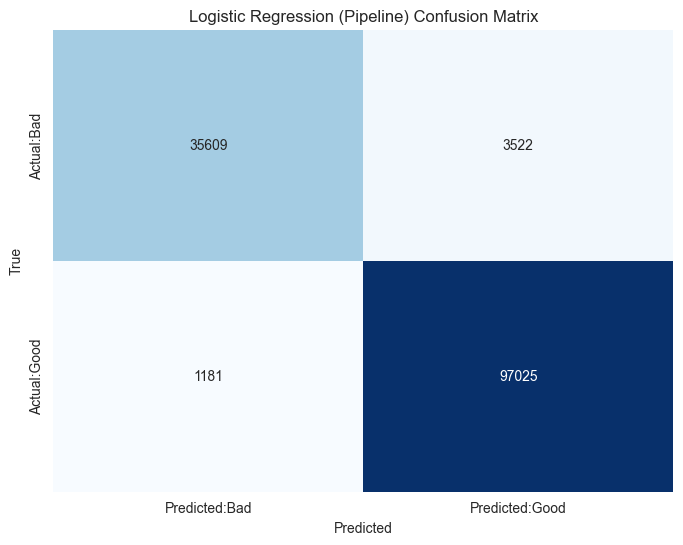

In [58]:
# Confusion Matrix for Logistic Regression from the pipeline
lr_pipeline_confusion_matrix = confusion_matrix(testY, lr_pipeline_predictions)
lr_pipeline_confusion_df = pd.DataFrame(lr_pipeline_confusion_matrix, columns=['Predicted:Bad', 'Predicted:Good'], index=['Actual:Bad', 'Actual:Good'])
plt.figure(figsize=(8, 6))
sns.heatmap(lr_pipeline_confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Logistic Regression (Pipeline) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [59]:
import pickle

# Save the Logistic Regression pipeline model to a file

with open('phishing_lr_pipeline.pkl', 'wb') as file:
    pickle.dump(lr_pipeline, file)

# Load the saved Logistic Regression pipeline model from a file
with open('phishing_lr_pipeline.pkl', 'rb') as file:
    loaded_lr_pipeline = pickle.load(file)

# List of URLs to predict
urls_good = ['https://www.youtube.com/watch?v=h-gTSQ9LXes', 'https://en.wikipedia.org/wiki/Sachin_Tendulkar', 'indianarmy.nic.in', 'https://en.wikipedia.org/wiki/Virat_Kohli', 'https://www.youtube.com/user/chandigarhuniversity']
urls_bad = ['https://10982nklag.com','https://ff-reward-redemption.blogspot.com/','https://djinjrgt.taplink.ws/', 'https://ptonlower20.sbs', 'http://kxtqmjfcqp.duckdns.org']
all_urls = urls_good + urls_bad

# Make predictions using the loaded Logistic Regression pipeline model
results = loaded_lr_pipeline.predict(all_urls)

# Print the results for each URL
for url, result in zip(all_urls, results):
    if result == 'good':
        print(f"URL: {url} -> Predicted: Good")
    else:
        print(f"URL: {url} -> Predicted: Bad")


URL: https://www.youtube.com/watch?v=h-gTSQ9LXes -> Predicted: Good
URL: https://en.wikipedia.org/wiki/Sachin_Tendulkar -> Predicted: Good
URL: indianarmy.nic.in -> Predicted: Good
URL: https://en.wikipedia.org/wiki/Virat_Kohli -> Predicted: Good
URL: https://www.youtube.com/user/chandigarhuniversity -> Predicted: Good
URL: https://10982nklag.com -> Predicted: Bad
URL: https://ff-reward-redemption.blogspot.com/ -> Predicted: Bad
URL: https://djinjrgt.taplink.ws/ -> Predicted: Bad
URL: https://ptonlower20.sbs -> Predicted: Bad
URL: http://kxtqmjfcqp.duckdns.org -> Predicted: Bad
